We want to create an initial set of template waveforms, one template being a three-component seismogram.

This is what we want to keep in mind to have for all three channels:
- Windows with both P- and S- pick
- Only one earthquake in the window
- Raw SNR > 2 for P-wave
- Raw SNR > 3 for S-wave
- Prioritize higher magnitudes first

To-do:
- For each earthquake, loop over all 3 channels and check P and S SNR in each
- If both SNRs are high enough for all 3 channels (6 checks), the event gets saved in a list

In [1]:
import obspy
import matplotlib.pyplot as plt
import numpy as np
import glob
import pandas as pd
import time; import datetime
from obspy.core.utcdatetime import UTCDateTime
from obspy.clients.fdsn.client import Client

In [2]:
def read_files(base_folder):
    ''' Reads in earthquake catalog files from CSS format into useful pandas dataframes
    
        Inputs:
        base_folder = string containing name of year and month of interest, e.g. '2019_01'
        
        Outputs dataframes:
        assoc
        arrivals
        origin
    '''
    
    
    base_dir = 'catalog_css/'+base_folder+'/'
    
    arr_files = glob.glob(base_dir + 'catalog_XO_*arrival')
    assoc_files = glob.glob(base_dir + 'catalog_XO_*assoc')
    origin_files = glob.glob(base_dir + 'catalog_XO_*origin')
    
    # Read data into pandas dataframe
    arrivals = pd.concat([pd.read_csv(f,header=None,delim_whitespace=True) for f in arr_files])
    assoc = pd.concat([pd.read_csv(f,header=None,delim_whitespace=True) for f in assoc_files])
    origin = pd.concat([pd.read_csv(f,header=None,delim_whitespace=True) for f in origin_files])

    # Rename some columns for clarity:
    assoc=assoc.rename(columns={0: "arrivalid", 1: "originid",2:"stationcode",3:"phase"})
    origin = origin.rename(columns={4:'originid',3:'epochtime',20:'magnitude'})
    arrivals=arrivals.rename(columns={2: "arrivalid", 6: "channel",0:"stationcode", 1:'epochtime',7:'phase'})
    
    return(assoc,arrivals,origin)

In [ ]:
def calc_snr(stream,sampleind,phase):
    # Calculate SNR of arrival
    # INPUTS:
    # stream = obspy-formatted waveform object
    # sampleind = index in the stream's data of desired arrival for which to calculate SNR
    # phase = type of arrival as a string, either 'P' or 'S'
    #
    # OUTPUT:
    # snr = float object of calculated SNR for the input index
    
    if phase == 'P':
        window = [5,5] # in seconds
    if phase == 'S':
        window = [5,5]
    data = stream[0].data
    sr = int(stream[0].stats.sampling_rate)
    snr_num = max(abs(data[sampleind:(sampleind+(window[0]*sr))]))
    snr_denom = np.std(data[(sampleind-(window[1]*sr)):sampleind])
    snr = snr_num/snr_denom
    return(snr)

1551996729.29
2019-03-07 22:12:09.288390


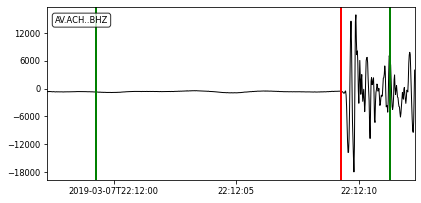

SNR = 163.440814076


KeyboardInterrupt: Interrupted by user

In [87]:
# Load catalog info for one month
month = '2019_03'
(assoc,arrivals,origin) = read_files(month)

# Sort events by magnitude, descending
origin = origin.sort_values(by=['magnitude'],ascending=False)
origin_ids = origin['originid']

# Loop through events
for id in origin_ids:

    # Get arrivals associated with this earthquake
    subset = assoc.loc[assoc['originid']==id]
    arrival_subset = arrivals.iloc[subset['arrivalid']-1]
    arrival_subset.reset_index(drop=True,inplace=True)
    
    # Get station names
    stations = arrival_subset['stationcode']

    # Get list of stations that have both P and S pick
    repeats = []
    for station in stations:
        sub = arrival_subset.loc[(arrival_subset['stationcode']==station)]
        if len(np.unique(sub['phase']))>1:
            repeats.append(station)
   
    # Loop through P-wave picks
    repeat_subset = arrival_subset.loc[(arrival_subset['stationcode'].isin(repeats))]
    repeat_subset = repeat_subset.drop_duplicates(subset=['stationcode'])
    repeat_subset.reset_index(drop=True,inplace=True)

    for i in range(0,len(repeat_subset)):
        pick = repeat_subset.iloc[i]
        
        # Skip global array stations that have low sample rates and complicated location codes
        if len(pick['stationcode'])>3:
            continue
            
        # P arrival time:
        pick_epoch = pick['epochtime']
        print(pick_epoch)
        basetime = datetime.datetime.utcfromtimestamp(pick_epoch)
        print(basetime)
        
        # We want the streams for x minutes before and after the pick time:
        t1 = UTCDateTime(basetime)-datetime.timedelta(minutes = 2)
        t2 = UTCDateTime(basetime)+datetime.timedelta(minutes = 10)

        # Now we query the data from IRIS for each of the stations 20 min before and after the origin time, and add it to the master stream:
        client = Client("IRIS")

        # Download the streams INCLUDING the instrument response:
        channel_base = pick['channel'][0:2]
        # st = client.get_waveforms("XO,AK,AV",pick['stationcode'], "--",channel_base+'*', t1, t2,attach_response=True)
        st = client.get_waveforms("XO,AK,AV",pick['stationcode'], "--",channel_base+'Z', t1, t2,attach_response=True)  
    
        # Plot the raw waveform:
        %matplotlib inline
        fig = plt.figure()
        t11 = UTCDateTime(basetime)-datetime.timedelta(seconds = 12)
        t22 = UTCDateTime(basetime)+datetime.timedelta(seconds = 3)
        st.plot(fig = fig,starttime=t11,endtime=t22) 
        plt.axvline(x=UTCDateTime(basetime),linewidth=2, color='r')
        plt.axvline(x=UTCDateTime(basetime)-datetime.timedelta(seconds = 10),linewidth=2,color='g')
        plt.axvline(x=UTCDateTime(basetime)+datetime.timedelta(seconds = 2),linewidth=2,color='g')
        plt.show()
        # st.spectrogram(log=True, title=str(st[0].stats.starttime))
        
        # Calculate SNR of arrival
        sr = int(st[0].stats.sampling_rate)
        p_sampleind = ((2*60)*sr)-1 # index of sample that contains P pick
        snr = calc_snr(st,p_sampleind,'P')
        print('SNR = ' + str(snr))


        input("Press Enter to continue...")


Below:
Loops over earthquakes, then loops over stations with both a P and S pick for that earthquake, and checks for which ones have P and S picks with high SNR on all 3 channels of the stations

LA39
HHZ
P SNR = 6.01795485575
S SNR = 6.89758897521


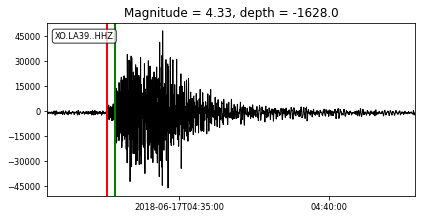

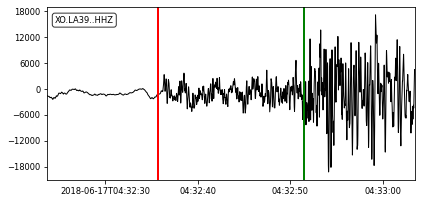

In [ ]:
# Load catalog info for one month
month = '2018_06'
(assoc,arrivals,origin) = read_files(month)

# Sort events by magnitude, descending
origin = origin.sort_values(by=['magnitude'],ascending=False)
origin_ids = origin['originid']

ev_count = -1
# Loop through events
for id in origin_ids:

    # Get magnitude for this earthquake
    ev_count += 1
    mag = origin.iloc[ev_count]['magnitude']
    
    # Get arrivals associated with this earthquake
    subset = assoc.loc[assoc['originid']==id]
    arrival_subset = arrivals.iloc[subset['arrivalid']-1]
    arrival_subset.reset_index(drop=True,inplace=True)
    
    # Get station names
    stations = arrival_subset['stationcode']

    # Get list of stations that have both P and S pick
    repeats = []
    for station in stations:
        sub = arrival_subset.loc[(arrival_subset['stationcode']==station)]
        if len(np.unique(sub['phase']))>1:
            repeats.append(station)
    repeat_subset = arrival_subset.loc[(arrival_subset['stationcode'].isin(repeats))]
    repeat_subset = repeat_subset.drop_duplicates(subset=['stationcode'])
    repeat_subset.reset_index(drop=True,inplace=True)

    # Loop over stations
    for i in range(0,len(repeat_subset)):
        pick = repeat_subset.iloc[i]
        station = pick['stationcode']
        p_pick = arrival_subset.loc[(arrival_subset['stationcode']==station)&(arrival_subset['phase']=='P')]
        s_pick = arrival_subset.loc[(arrival_subset['stationcode']==station)&(arrival_subset['phase']=='S')]
        p_time = datetime.datetime.utcfromtimestamp(p_pick.iloc[0]['epochtime'])
        s_time = datetime.datetime.utcfromtimestamp(s_pick.iloc[0]['epochtime'])
        
        # We want the streams for 2 minutes before the P time and 10 minutes after the S time:
        t1 = UTCDateTime(p_time)-datetime.timedelta(minutes = 2)
        t2 = UTCDateTime(s_time)+datetime.timedelta(minutes = 10)
        channel_base = p_pick.iloc[0]['channel'][0:2]
        channels = [channel_base+'Z',channel_base+'E,'+channel_base+'1',channel_base+'N,'+channel_base+'2']

        
        # Loop over channels
        j = 0
        while j < 3:
            # Now we query the data from IRIS for the time band defined above:
            client = Client("IRIS")
            print(station)
            print(channels[j])
            # Only do OBS stations!!!
            try:
                st = client.get_waveforms("XO",station, "--",channels[j], t1, t2,attach_response=True)
            except:
                j=3
            
            station_mda = client.get_stations(network="XO", station=station)
            elev = station_mda[0][0].elevation
            
            # Get index of the P and S pick
            nsamples = len(st[0].data)
            sr = int(st[0].stats.sampling_rate)
            p_sampleind = ((2*60)*sr)-1 # index of sample that contains P pick
            s_sampleind = nsamples - ((10*60)*sr) # index of sample that contains S pick
            
            # Calculate SNR of P and S pick
            p_snr = calc_snr(st,p_sampleind,'P')
            print('P SNR = ' + str(p_snr))
            if p_snr < 2:
                j = 3
            s_snr = calc_snr(st,s_sampleind,'S')
            print('S SNR = ' + str(s_snr))
            if s_snr < 3:
                j = 3
            j += 1
            
            %matplotlib inline
            fig = plt.figure()
            st.plot(fig = fig,starttime=t1,endtime=t2) 
            plt.axvline(x=(p_time),linewidth=2, color='r')
            plt.axvline(x=UTCDateTime(s_time),linewidth=2, color='g')
            plt.title('Magnitude = '+str(mag)+', depth = '+str(elev))
            plt.show()
            fig = plt.figure()
            st.plot(fig = fig,starttime=UTCDateTime(p_time)-datetime.timedelta(seconds = 12),endtime=UTCDateTime(s_time)+datetime.timedelta(seconds = 12)) 
            plt.axvline(x=(p_time),linewidth=2, color='r')
            plt.axvline(x=UTCDateTime(s_time),linewidth=2, color='g')
            plt.show()
            input("Press Enter to continue...")
            

    
        